In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from CinePred.new_model import *
from CinePred.data.preprocessing import *
from CinePred.data.importing import import_data
from CinePred.data.featuring import add_inflation

from sklearn.model_selection import cross_val_score, GridSearchCV
from xgboost import XGBRegressor, plot_importance
from matplotlib import pyplot
import numpy as np
from sklearn.inspection import permutation_importance

In [6]:
df = import_data('../raw_data/IMDb_movies.csv')

In [7]:
df = preproc(df, path="../raw_data/cat_acteur.csv")

11890
13194
13194
(13194, 25)


##### Chapeau

In [38]:
import pandas as pd

In [39]:
acteurs_df = pd.read_csv("../raw_data/cat_acteur.csv")

In [40]:
acteurs_df.head()

,Unnamed: 0,title,shifted,acteur_name,year,month,budget,income,ratio
0,0,#Selfieparty,0,Ksenia Mishina,2016,3,100000.0,179458,1.794580
1,1,#Selfieparty,0,Pavlo Li,2016,3,100000.0,179458,1.794580
2,2,#Selfieparty,0,Olena Lavrenyuk,2016,3,100000.0,179458,1.794580
3,3,'Chi chi' de ai,0,Dee Hsu,2017,5,1500000.0,4013033,2.675355
4,4,'Chi chi' de ai,0,Kim Scar,2017,5,1500000.0,4013033,2.675355


In [41]:
# acteurs_df.groupby(by='acteur_name').mean()

# acteurs_df.groupby(by='acteur_name').max()['shifted'].sort_values(ascending=False).head(10)

# acteurs_df.groupby(by='acteur_name').mean()['income'].sort_values(ascending=False).head(10)

# acteurs_df.groupby(by='acteur_name').mean()['budget'].sort_values(ascending=False).head(10)

# acteurs_df.groupby(by='acteur_name').mean()['ratio'].sort_values(ascending=False).head(10)

In [42]:
acteurs_df['year'] = convert_to_int(acteurs_df[['year']])
acteurs_df.sort_values(by='year', inplace=True)
acteurs_df['ones'] = 1
acteurs_df['last income'] = acteurs_df['income']

In [43]:
acteurs_df['last income'] = acteurs_df.groupby(by='acteur_name')['last income'].transform(lambda x: x.shift(1, fill_value=0))
acteurs_df

,Unnamed: 0,title,shifted,acteur_name,year,month,budget,income,ratio,ones,last income
13749,13749,Il gabinetto del dottor Caligari,0,Werner Krauss,1920,2,1.800000e+04,8811,0.489500,1,0
13748,13748,Il gabinetto del dottor Caligari,0,Conrad Veidt,1920,2,1.800000e+04,8811,0.489500,1,0
13750,13750,Il gabinetto del dottor Caligari,0,Friedrich Feher,1920,2,1.800000e+04,8811,0.489500,1,0
21464,21464,Markens grøde,0,Amund Rydland,1921,12,2.926274e+04,4272,0.145988,1,0
21463,21463,Markens grøde,0,Karen Poulsen,1921,12,2.926274e+04,4272,0.145988,1,0
...,...,...,...,...,...,...,...,...,...,...,...
33430,33430,Tobulas Pasimatymas,5,Leon,2020,1,2.314800e+05,947455,4.093032,1,1344070
6905,6905,Cut Throat City,0,Eiza González,2020,8,8.000000e+06,507974,0.063497,1,30855391
6904,6904,Cut Throat City,0,Ethan Hawke,2020,8,8.000000e+06,507974,0.063497,1,79603
24583,24583,Padre no hay más que uno 2: La llegada de la s...,0,Santiago Segura,2020,7,4.700000e+06,11700000,2.489362,1,15894372


In [44]:
#actors.rename(columns={"income" : "last_income"}, inplace=True)

In [45]:
#acteurs_df[acteurs_df.acteur_name =='Leonardo DiCaprio']

In [46]:
acteurs_df = acteurs_df.groupby(by='title').agg({'last income' : 'sum'})
acteurs_df

,last income
title,
#Selfieparty,0
'Chi chi' de ai,47164301
'Z' fung bou,28224313
'n Beetje Verliefd,0
(500) giorni insieme,257636813
...,...
Întâlniri încrucisate,127781
Órói,0
Ögrenci Isleri,68669


In [47]:
acteurs_df.reset_index(inplace=True)
acteurs_df = acteurs_df.rename(columns = {'index':'acteur_name'})
acteurs_df

,title,last income
0,#Selfieparty,0
1,'Chi chi' de ai,47164301
2,'Z' fung bou,28224313
3,'n Beetje Verliefd,0
4,(500) giorni insieme,257636813
...,...,...
11885,Întâlniri încrucisate,127781
11886,Órói,0
11887,Ögrenci Isleri,68669
11888,Öldür beni,0


In [48]:
df = df.merge(right=acteurs_df, on='title', how="left")
df

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,last income
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0,NaN
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,...,True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0,NaN
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0,NaN
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0,193789846.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,Loosely adapted from Dante's Divine Comedy and...,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85850,tt9908390,Le lion,Le lion,2020,2020-01-29,Comedy,95,"France, Belgium",French,Ludovic Colbeau-Justin,...,A psychiatric hospital patient pretends to be ...,5.3,398,NaN,NaN,$ 3507171,NaN,NaN,4.0,NaN
85851,tt9911196,De Beentjes van Sint-Hildegard,De Beentjes van Sint-Hildegard,2020,2020-02-13,"Comedy, Drama",103,Netherlands,"German, Dutch",Johan Nijenhuis,...,A middle-aged veterinary surgeon believes his ...,7.7,724,NaN,NaN,$ 7299062,NaN,6.0,4.0,NaN
85852,tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,2019,2019-03-08,Drama,130,India,Malayalam,Vineesh Aaradya,...,NaN,7.9,265,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85853,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,2019-03-15,"Drama, Family",98,Turkey,Turkish,Ahmet Faik Akinci,...,NaN,6.4,194,NaN,NaN,$ 2833,NaN,NaN,NaN,NaN


In [43]:
acteurs_df[acteurs_df.acteur_name =='Leonardo DiCaprio']

,Unnamed: 0,title,shifted,acteur_name,year,month,budget,income,ratio,ones,last_income
5901,4834,Buon compleanno Mr. Grape,0,Leonardo DiCaprio,1993,3,11000000.0,10032765,0.912070,1,374343626
6543,27162,Ritorno dal nulla,0,Leonardo DiCaprio,1995,4,2000000.0,2381087,1.190543,1,374343626
6736,25533,Poeti dall'inferno,0,Leonardo DiCaprio,1995,8,8000000.0,340139,0.042517,1,374343626
7362,27335,Romeo + Giulietta di William Shakespeare,0,Leonardo DiCaprio,1996,2,14500000.0,151842560,10.471901,1,374343626
7381,19141,La stanza di Marvin,0,Leonardo DiCaprio,1996,4,23000000.0,12803305,0.556665,1,374343626
8071,33410,Titanic,0,Leonardo DiCaprio,1997,1,200000000.0,2195169869,10.975849,1,374343626
8610,18555,La maschera di ferro,2,Leonardo DiCaprio,1998,3,35000000.0,182968902,5.227683,1,374343626
9685,31135,The Beach,2,Leonardo DiCaprio,2000,2,50000000.0,144056873,2.881137,1,374343626
11371,26005,Prova a prendermi,2,Leonardo DiCaprio,2002,1,52000000.0,352114312,6.771429,1,374343626
11850,10535,Gangs of New York,2,Leonardo DiCaprio,2002,1,100000000.0,193772504,1.937725,1,374343626


#### Clean

In [5]:
# NA & columns:
df = add_success_movies_per_actors(df, path = "../raw_data/cat_acteur.csv")
    
df = keep_columns(df,
                      column_names=[
                          'year', 'date_published', 'genre', 'duration',
                          'budget', 'worlwide_gross_income',
                          'production_company', 'director', 'writer', 'shifted'
                      ])
df = remove_na_rows(df)

In [6]:
# date_published
df['date_published'] = convert_to_date(df[['date_published']])

# day of the year
df['date_sin'] = add_sin_features(df[['date_published']])
df['date_cos'] = add_cos_features(df[['date_published']])
df.drop(columns='date_published', inplace=True)

# year, duration
df['year'] = convert_to_int(df[['year']])
df['duration'] = convert_to_int(df[['duration']])

# genre
ohe = GenreOHE()
ohe.fit(df) # la colonne 'genre' est spécifié dans la classe
df = ohe.transform(df)

# budget
df['budget'] = convert_budget_column(df[['budget']])
df = df[df['budget'] > 100]
df = add_inflation(df, 'budget')
df['budget'] = log_transformation(df[['budget']])

# income
df['worlwide_gross_income'] = convert_income(df[['worlwide_gross_income']])
df = add_inflation(df, 'worlwide_gross_income')
df['worlwide_gross_income'] = log_transformation(df[['worlwide_gross_income']])

# cumsum
df = Add_Ones(df)
df = Add_number_of_movies_per_prod_company_in_Timeline(df)
df = Add_number_of_movies_per_directors_in_Timeline(df)
df = Add_number_of_movies_per_writer_in_Timeline(df)
df = Remove_Ones(df)

# sort & index:
df.sort_values('budget', inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index', 'production_company', 'director', 'writer'],
        inplace=True)

In [7]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#### Model fit

In [8]:
mid = int(df.shape[0] / 2)
df1 = df.iloc[:mid].copy()
df2 = df.iloc[mid:].copy()

In [9]:
X = df1.drop(columns=['worlwide_gross_income'])
y = df1['worlwide_gross_income']

model = XGBRegressor(learning_rate=0.1, max_depth=2)

cv = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

In [10]:
X2 = df2.drop(columns=['worlwide_gross_income'])
y2 = df2['worlwide_gross_income']
model2 = XGBRegressor(learning_rate=0.1, max_depth=2)
cv2 = cross_val_score(model2, X2, y2, cv=5, scoring='neg_mean_absolute_error')

In [11]:
score1 = np.mean(np.abs(cv)) # {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}

In [12]:
score2 = np.mean(np.abs(cv2))

In [13]:
print(score1, score2)

0.7456000007423738 0.4737402627342505


In [14]:
X2

,year,duration,budget,shifted,nb_movies_actor1,reviews_from_critics,last income,date_sin,date_cos,Romance,...,Sport,Thriller,Mystery,Horror,Family,Music,Documentary,Nb_actuals_movie_production_company,Nb_actuals_movie_directors,Nb_actuals_movie_writers
5832,2011,99,7.093557,0,1,17.0,0,-8.660254e-01,5.000000e-01,0,...,1,0,0,0,0,0,0,1,7,1
5833,2011,114,7.093557,2,1,71.0,54446818,-1.000000e+00,-1.836970e-16,0,...,0,0,0,0,0,0,0,1,10,1
5834,2003,97,7.093663,0,1,7.0,6477370,1.224647e-16,-1.000000e+00,0,...,0,0,0,0,0,0,0,9,1,1
5835,1999,100,7.094398,0,2,39.0,71046245,-8.660254e-01,-5.000000e-01,0,...,0,0,0,0,0,0,0,1,1,1
5836,1999,89,7.094398,0,4,11.0,17890418,5.000000e-01,-8.660254e-01,0,...,0,0,0,0,0,0,0,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11659,2019,181,8.564574,16,34,557.0,4139788762,8.660254e-01,-5.000000e-01,0,...,0,0,0,0,0,0,0,12,6,8
11660,1963,192,8.570714,1,1,87.0,193789846,5.000000e-01,8.660254e-01,0,...,0,0,0,0,0,0,0,18,5,1
11661,2007,169,8.573417,6,9,327.0,1873827367,5.000000e-01,-8.660254e-01,0,...,0,0,0,0,0,0,0,63,7,3
11662,1959,126,8.834959,0,1,17.0,0,1.000000e+00,6.123234e-17,0,...,0,0,0,0,0,0,0,1,1,1


#### Feature importance

In [15]:
model2.fit(X2, y2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [16]:
permutation_score = permutation_importance(model2, X2, y2, n_repeats=10) # Perform Permutation

importance_df = pd.DataFrame(np.vstack((X2.columns,
                                        permutation_score.importances_mean)).T) # Unstack results
importance_df.columns=['feature','score decrease']

importance_df.sort_values(by="score decrease", ascending = False) # Order by importance

,feature,score decrease
5,reviews_from_critics,0.500049
2,budget,0.199428
0,year,0.150358
31,Nb_actuals_movie_production_company,0.0352
13,Comedy,0.02279
1,duration,0.010291
28,Family,0.009962
32,Nb_actuals_movie_directors,0.007196
17,Animation,0.0038
19,Drama,0.003587


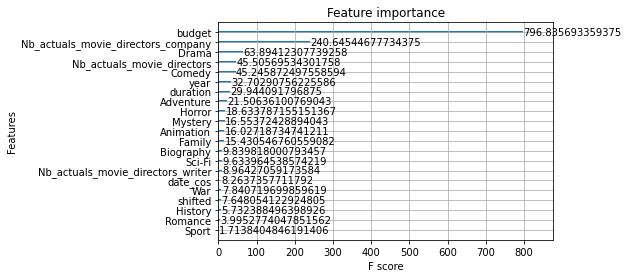

In [33]:
plot_importance(model, importance_type='gain')
pyplot.show()

In [23]:
d = {'name': list(X.columns), 'importance': list(model.feature_importances_)}

data = pd.DataFrame(d)

data.sort_values(by="importance", ascending=False)

In [ ]:
X = X.drop(columns=['Music', "Thriller", 'date_sin', 'Action', 'Documentary', 'Film-Noir', 'Fantasy', 'Musical', 'Western', 'Crime'])